## **Data Preprocessing**


### **!!!!! TODO INTRODUCERE IN DATA PREPROCESSING!!!!**

#### **Loading relational MIMIC3 tables**

- Importing the files with details of ICU patient episodes. 

In [295]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')           # Item descriptions
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')        # ICU stay times
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) # Chart 

##### TODO choosing the disease
- Filtering for ICD-9 code 48283, corresponding to bacterial pneumonia.
- High ICU admission rates -> clinically and epidemiologically relevant for LOS modeling.
- 264 rows = 264 hospital admissions found.

In [296]:
# Filter for Pneumonia (ICD-9 = 48283)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)

df_target.head()

(264, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
38,114,178393,48283
4202,339,112625,48283
5063,285,165312,48283
7541,605,115545,48283
8075,720,171046,48283


#### **Joining tables**

- Joining admissions with the respective patient data

In [297]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(264, 5)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO
3,605,115545,48283,2197-11-09 12:59:00,ASIAN
4,720,171046,48283,2160-02-15 21:44:00,WHITE


- Joining table with ICU stays
- Appending relevant patient demographics that influence the prediction

In [298]:
# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)
print(df_merged.shape)

df_merged.isnull().sum()


(307, 10)


SUBJECT_ID    0
HADM_ID       0
ICD9_CODE     0
ADMITTIME     0
ETHNICITY     0
ICUSTAY_ID    0
INTIME        0
LOS           0
GENDER        0
DOB           0
dtype: int64

#### **Feature Derivation and Data Filtering**

- Age is estimated using admission and birth year due to incomplete date precision in MIMIC-III.
- HIPAA constraints on patients ≥89 are mitigated by recoding to 91.
- Short stays (<1 day) and extreme LOS outliers are excluded to reduce heteroscedasticity and improve model generalizability.

In [299]:
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])
df_merged['INTIME'] = pd.to_datetime(df_merged['INTIME'])
df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])

# Subtract the years
df_merged['AGE'] = (
    (df_merged['INTIME'].dt.year - df_merged['DOB'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['DOB'].dt.dayofyear) / 365.25
)

# Time since admitted in the hospital
df_merged['HOSP_TIME'] = (
    (df_merged['INTIME'].dt.year - df_merged['ADMITTIME'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['ADMITTIME'].dt.dayofyear) / 365.25
)

df_merged.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

df_merged.loc[df_merged['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.nsmallest(len(df_merged), 'LOS')  # Remove 2 max LOS rows 
    
df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379


#### **Exploratory Cohort Profiling**

- To examine the distributional extremes of ICU length of stay (LOS), the dataset was sorted in both ascending and descending order.
- Sorting to easily choose 3 patients for closely examining and charting.

In [300]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'AGE']].head())

Top 5 Shortest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID     LOS              INTIME        AGE
287       87980   110615      243965  1.1159 2142-05-02 15:03:18  65.748118
291       94937   162005      280084  1.1432 2107-01-18 11:11:21  68.389459
244       63941   126602      270748  1.1496 2196-04-23 14:49:48  74.917864
14         3078   147024      272986  1.1541 2175-12-09 15:03:51  47.793977
29         5062   123244      250261  1.2110 2100-12-10 12:50:48  71.835044


In [301]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'AGE']].head())


Top 5 Longest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS        AGE
43         6702   157559      220172  84.0409  80.644079
106       16025   155705      285837  75.7236  57.125941
53         7085   106726      283819  60.7469  42.027379
138       21312   150854      213825  55.6920  76.547570
140       22818   188392      241236  55.6687  73.405202


- ```.shape``` indicating the ICU stays
- ```.describe``` used for inspecting the statistics (mostly LOS and age) 

In [302]:
df_merged.shape

(297, 10)

In [303]:
# df_merged.describe().T

#### **Outcome Transformation**

- Log-transformation of LOS stabilizes variance and addresses right-skew 

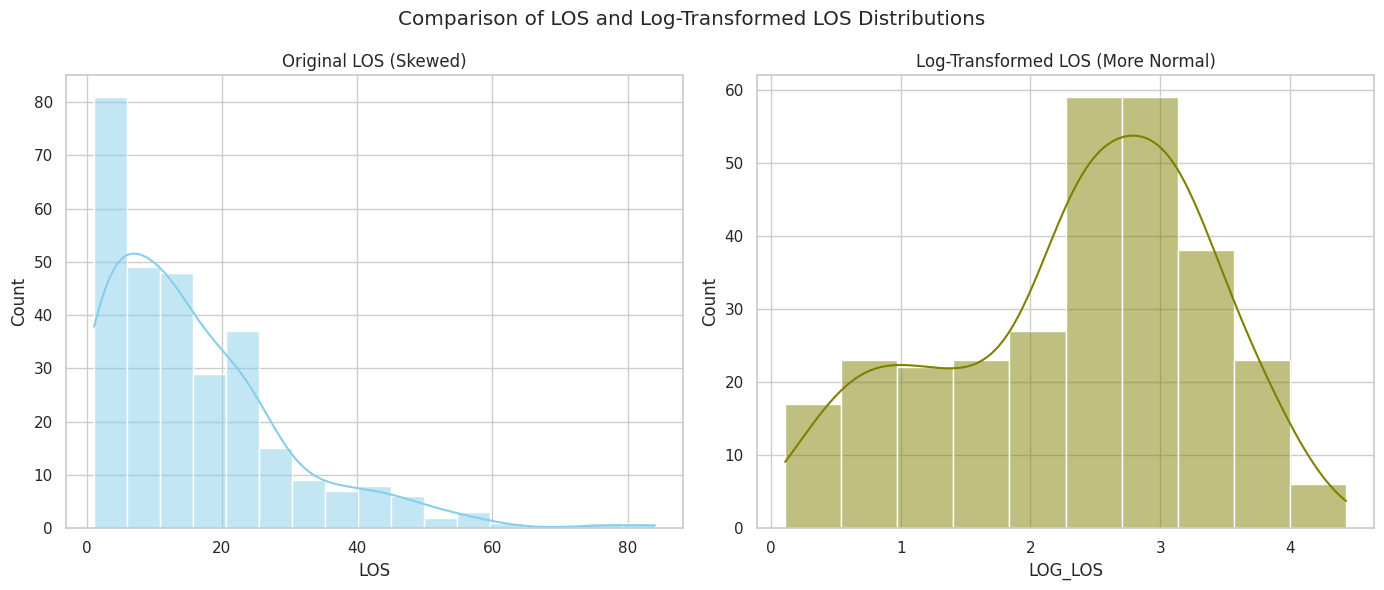

In [304]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

- Distribution closer to Gaussian distribution, enabling the use of a wider range of models.

#### **Temporal Framing of ICU Episodes**

Three representative ICU stays were manually selected for a 24-hour observation window.  

In [305]:
selected_small_id = 220271
selected_mean_id =  284345
selected_big_id = 200375

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
icu_info

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
22486,25628,20190,119413,200375,carevue,CCU,CSRU,57,14,2138-10-15 23:22:54,2138-11-11 12:05:15,26.5294


In [306]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

starttime, endtime

(Timestamp('2138-10-15 23:22:54'), Timestamp('2138-10-16 23:22:54'))

#### **Chart Data Integration and Availability Assessment**

Re-validating the merged dataset post-filtering:

In [307]:
print(df_merged.shape)
df_merged.head()

(297, 11)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME,LOG_LOS
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000,0.109661
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393,0.133831
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738,0.139414
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903,0.143321
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379,0.191446


- An SQL query is executed to filter only the chartevents of the admissions with the pneumonia diagnostic into 'pneumonia.csv' for faster and easier access
- The filtered subset of the CHARTEVENTS table—specific to the pneumonia cohort is loaded. 

In [308]:
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 
 
# print(df_chart_events.shape)      
# df_chart_events.head()

- Joining with chart events measurements. 
- Stratification of patients into those with vs. without structured chart data.

In [309]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged,  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME','VALUEUOM']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

print(df_merged_with_chartevents.shape)

df_merged_with_chartevents.head()

ICU stays WITH CHARTEVENTS data: 140
ICU stays WITHOUT CHARTEVENTS data: 157
(986502, 16)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge
0,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,220277.0,94.0,2142-05-02 15:19:00,%,both
1,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg,both
2,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg,both
3,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F,both
4,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223769.0,100.0,2142-05-02 15:19:00,%,both


In [310]:
df_final = df_merged_with_chartevents[df_merged_with_chartevents['_merge'] == 'both'].copy()

# Optional: You can now drop the '_merge' column as it's no longer needed
df_final = df_final.drop(columns=['_merge'])

print(f"Shape of the original DataFrame: {df_merged_with_chartevents.shape}")
print(f"Shape of the final DataFrame (with data): {df_final.shape}")
df_final.head()

Shape of the original DataFrame: (986502, 16)
Shape of the final DataFrame (with data): (986345, 15)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM
0,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,220277.0,94.0,2142-05-02 15:19:00,%
1,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg
2,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg
3,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F
4,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223769.0,100.0,2142-05-02 15:19:00,%


In [311]:
df_final.shape

(986345, 15)

- We can only use the ICU stays with chartevents (140), filtering out the rest
- Initially, we chose bronchitis, but too few ICU stays with chart events are not enough to train and validate the model
![Alt Text](./bronchitis_results.png)

#### **First 24 hour ICU window**

- creating the patients first 24 hour window in ICU
- analyzing the number of items administrated during this window

(92007, 16)


<Axes: xlabel='ITM_ADM_TIME', ylabel='Count'>

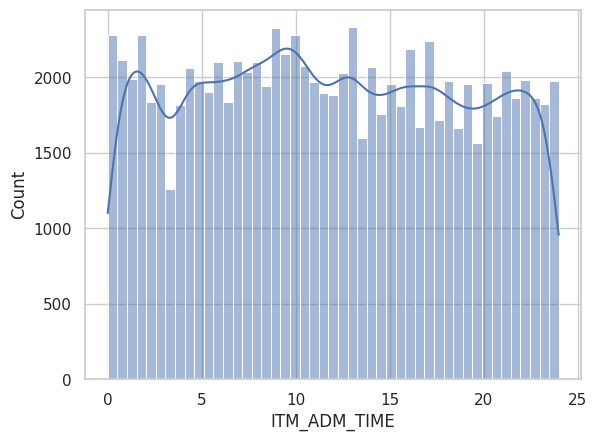

In [312]:
df_final['INTIME'] = pd.to_datetime(df_final['INTIME'])
df_final['CHARTTIME'] = pd.to_datetime(df_final['CHARTTIME'])

# df_final.isnull().sum()

df_final['ITM_ADM_TIME'] = (df_final['CHARTTIME'] - df_final['INTIME']).dt.total_seconds() / 3600
df_final = df_final[(df_final['ITM_ADM_TIME'] <= 24) & (df_final['ITM_ADM_TIME'] >= 0)]
# df_merged_with_chartevents.describe()

print(df_final.shape)
sns.histplot(df_final['ITM_ADM_TIME'], kde=True)

- normalizing the window time to a (0, 1) interval
- makes a larger variety of models easier to be trained
- it's easier to interpret results this way

<Axes: xlabel='ITM_ADM_TIME', ylabel='Count'>

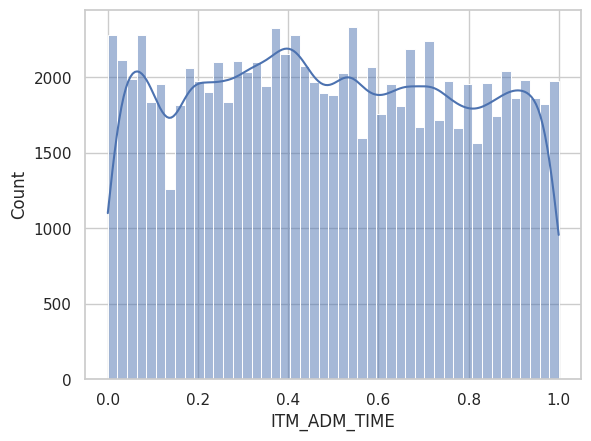

In [313]:
df_final['ITM_ADM_TIME'] = df_final['ITM_ADM_TIME'] / 24.0

sns.histplot(df_final['ITM_ADM_TIME'], kde=True)

#### **Choosing 3 patients**

- chose 3 patients with little, medium and high length of stay in the time window in order to visualise different trends

In [314]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load the dataset once
df = pd.read_csv("./data_sets/norm_pneumonia.csv")
df['ITM_ADM_TIME'] = df['NORMTIME']
df.drop(columns='NORMTIME')
# Define plotting function
def plot_icu_data(icu_id):
    filtered = df[df["ICUSTAY_ID"] == icu_id]
    value_min = 0
    value_max = 200
    filtered_limited = filtered[
        (filtered["VALUENUM"] >= value_min) & (filtered["VALUENUM"] <= value_max)
    ]

    # Prepare LOWESS smoothed values
    x = filtered_limited["ITM_ADM_TIME"]
    y = filtered_limited["VALUENUM"]
    lowess_smoothed = lowess(y, x, frac=0.3, return_sorted=True)
    lowess_x = lowess_smoothed[:, 0]
    lowess_y = lowess_smoothed[:, 1]

    # Bootstrap for confidence interval
    bootstraps = []
    for _ in range(100):
        sample = filtered_limited.sample(frac=1, replace=True)
        smoothed = lowess(sample["VALUENUM"], sample["ITM_ADM_TIME"], frac=0.3, return_sorted=True)
        bootstraps.append(np.interp(lowess_x, smoothed[:, 0], smoothed[:, 1]))
    bootstraps = np.array(bootstraps)
    ci_lower = np.percentile(bootstraps, 2.5, axis=0)
    ci_upper = np.percentile(bootstraps, 97.5, axis=0)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.set(style="whitegrid")

    sns.scatterplot(
        data=filtered_limited,
        x="ITM_ADM_TIME",
        y="VALUENUM",
        hue="ITEMID",
        palette="Blues",
        alpha=0.8
    )

    # Add LOWESS trend line
    plt.plot(lowess_x, lowess_y, color="blue", label="Trend")

    # Add ribbon (confidence interval)
    plt.fill_between(lowess_x, ci_lower, ci_upper, color="blue", alpha=0.2, label="95% CI")

    # Adjust legend
    plt.legend(title="ITEMID", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"ICU_{icu_id}", fontsize=16)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.tight_layout()
    plt.show()


##### Little length of stay

/home/cox/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


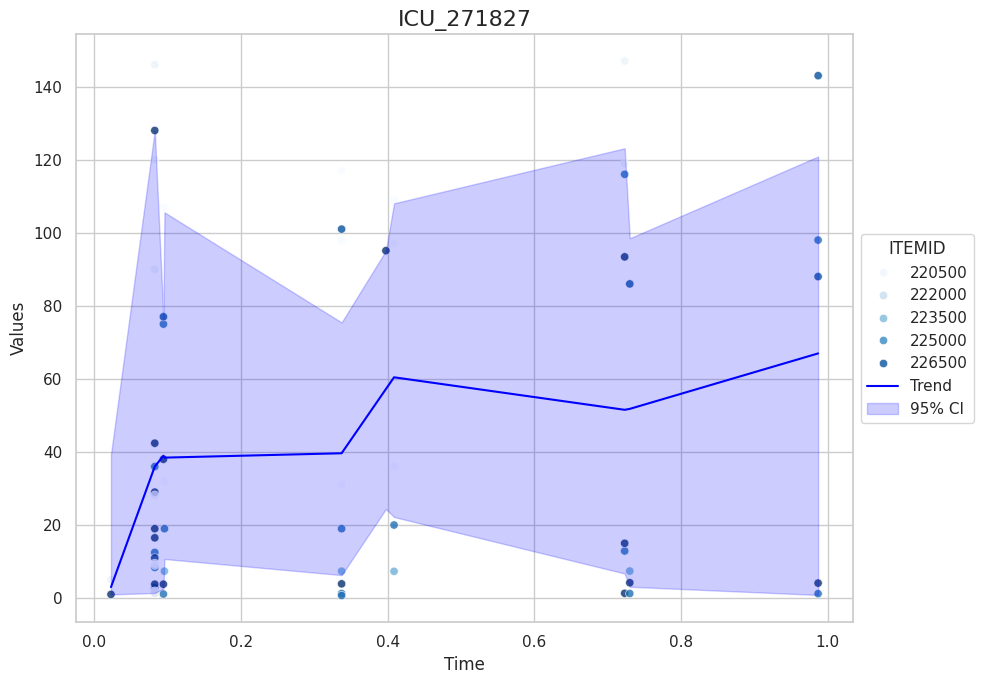

In [315]:
plot_icu_data(icu_id=271827)

##### Medium length of stay

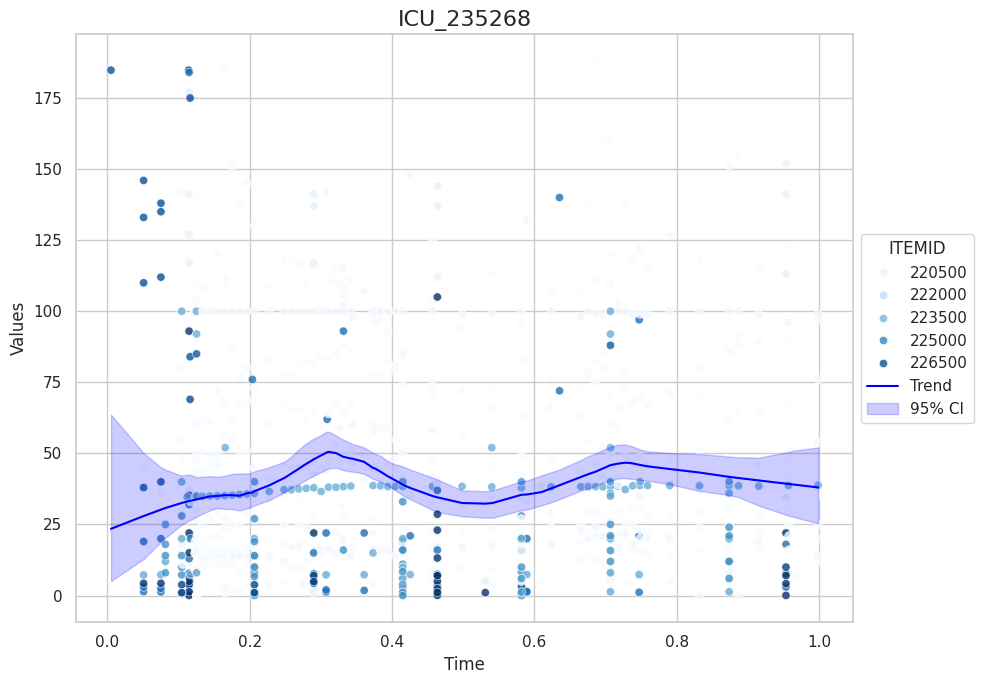

In [316]:
plot_icu_data(icu_id=235268)

##### High length of stay

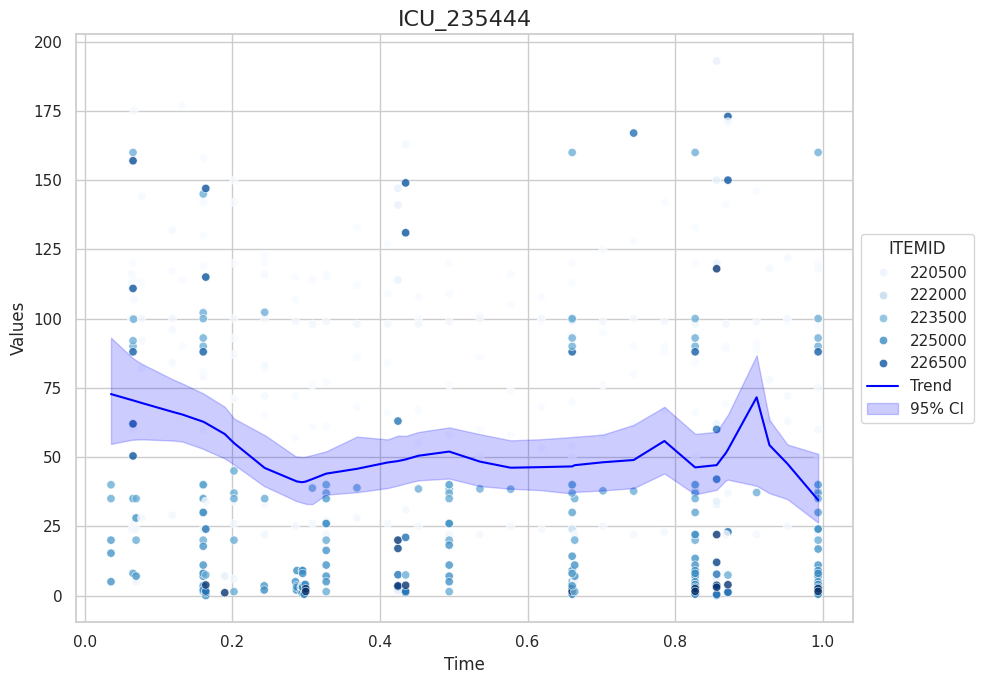

In [317]:
plot_icu_data(icu_id=235444)